In [1]:
import pandas as pd
import os
from collections import Counter
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from math import sqrt
import warnings
warnings.filterwarnings("ignore")
from keras.models import Sequential
from keras.layers import Dense, Dropout
from sklearn.preprocessing import MinMaxScaler

Using TensorFlow backend.


In [2]:
os.chdir('C:\\Users\\zhong\\git\\Bikeshare\\Data')

In [3]:
df = pd.read_csv("hourly.csv")

In [4]:
df.dteday = pd.to_datetime(df.dteday)

## Modify data type for categorical variables

In [5]:
df.season = df.season.astype("category")
df.yr = df.yr.astype("category")
df.mnth = df.mnth.astype("category")
df.hr = df.hr.astype("category")
df.holiday = df.holiday.astype("category")
df.weekday = df.weekday.astype("category")
df.workingday = df.workingday.astype("category")
df.weathersit = df.weathersit.astype("category")

In [6]:
df.isna().sum().sum()

0

No NA

## Data Visualization

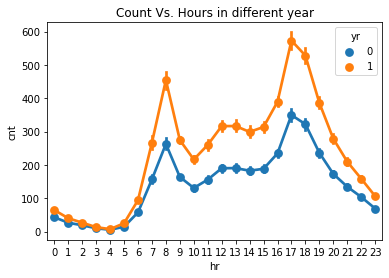

In [7]:
sns.pointplot(x = df.hr,y = df.cnt, hue =df.yr)
plt.title("Count Vs. Hours in different year")
plt.show()

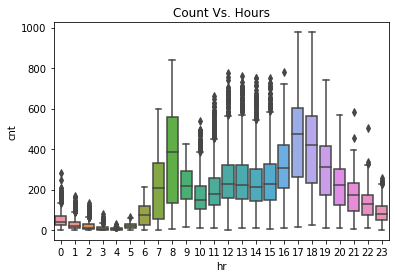

In [8]:
sns.boxplot(y=df.cnt,x=df.hr)
plt.title("Count Vs. Hours")
plt.show()

We can observed the peak hours are at 8 and 17,18.

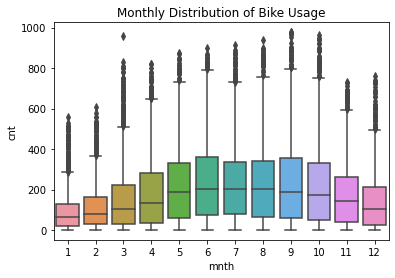

In [9]:
sns.boxplot(y=df.cnt,x=df.mnth)
plt.title("Monthly Distribution of Bike Usage")
plt.show()

From this plot, we can observe there is a significant difference of bike usage in some months.

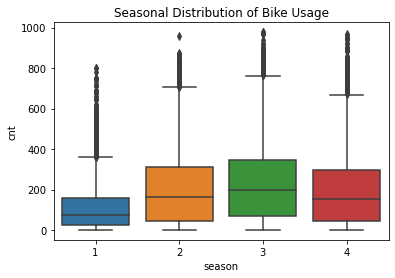

In [10]:
sns.boxplot(y=df.cnt,x=df.season)
plt.title("Seasonal Distribution of Bike Usage")
plt.show()

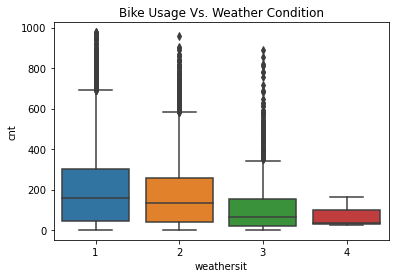

In [11]:
sns.boxplot(y=df.cnt,x=df.weathersit)
plt.title("Bike Usage Vs. Weather Condition")
plt.show()

- 1: Clear, Few clouds, Partly cloudy, Partly cloudy
- 2: Mist + Cloudy, Mist + Broken clouds, Mist + Few clouds, Mist
- 3: Light Snow, Light Rain + Thunderstorm + Scattered clouds, Light Rain + Scattered clouds
- 4: Heavy Rain + Ice Pallets + Thunderstorm + Mist, Snow + Fog

This plot makes sense. Better weather = more bike usage.

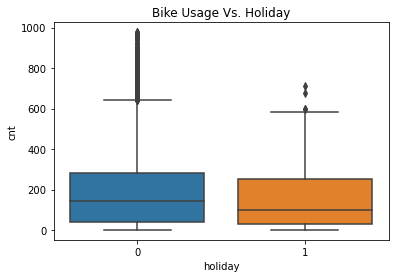

In [12]:
sns.boxplot(y=df.cnt,x=df.holiday)
plt.title("Bike Usage Vs. Holiday")
plt.show()

Before making this plot, I would think there would be usage difference if it is a holiday or not.

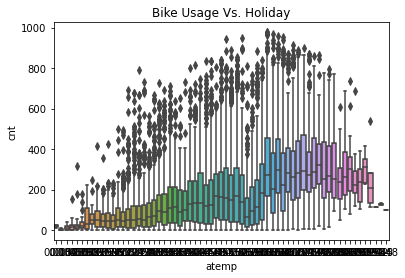

In [13]:
sns.boxplot(y=df.cnt,x=df.atemp)
plt.title("Bike Usage Vs. Holiday")
plt.show()

From this plot, we can tell there is a significant increase when temperature increase.

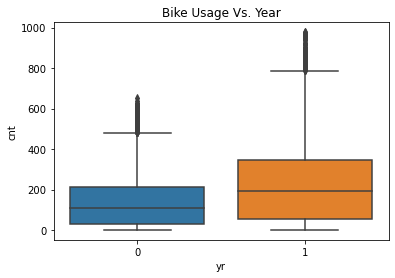

In [14]:
sns.boxplot(y=df.cnt,x=df.yr)
plt.title("Bike Usage Vs. Year")
plt.show()

## Correlation Map

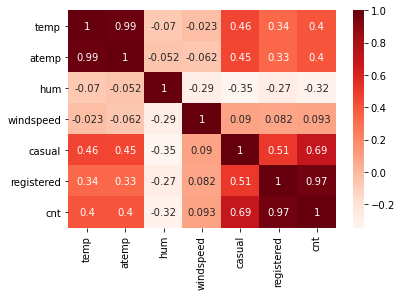

In [67]:
sns.heatmap(df.drop(["instant"],axis=1).corr(), annot=True, cmap="Reds")
plt.show()

## Feature Selection

In [16]:
features = df.columns
features

Index(['instant', 'dteday', 'season', 'yr', 'mnth', 'hr', 'holiday', 'weekday',
       'workingday', 'weathersit', 'temp', 'atemp', 'hum', 'windspeed',
       'casual', 'registered', 'cnt'],
      dtype='object')

Column casual and registered will be removed because cnt is the sum of these two columns. Our target is cnt.<br>
We will keep temp instead of atemp because they are the same feature in different scale <br>
We already have year column so we will remove dteday. <br>
Column windspeed shows a non significant relation with count.

In [17]:
featuresupdate = features.drop(["instant","atemp","casual","registered","dteday","windspeed"])
featuresupdate

Index(['season', 'yr', 'mnth', 'hr', 'holiday', 'weekday', 'workingday',
       'weathersit', 'temp', 'hum', 'cnt'],
      dtype='object')

In [18]:
X=df[featuresupdate].iloc[:,0:-1]
y=df[featuresupdate][["cnt"]]

## Encode Categorical Variable

In [19]:
X = pd.get_dummies(X,drop_first = True)

## Split Data

In [20]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.25)

## Create Linear Regression Model

In [21]:
linearModel=LinearRegression()
linearModel.fit(X=X_train,y=y_train)
prediction = linearModel.predict(X_test)
sqrt(mean_squared_error(prediction,y_test))

100.28473433931961

In [22]:
linearModel.score(X_train,y_train)

0.6860594247917452

## Numerical Data Normalization

In [23]:
sc = MinMaxScaler(feature_range=(0,1))
sc.fit(X_train.iloc[:,0:2])
X_train.iloc[:,0:2] = sc.transform(X_train.iloc[:,0:2])
X_test.iloc[:,0:2] = sc.transform(X_test.iloc[:,0:2])
X_val.iloc[:,0:2] = sc.transform(X_val.iloc[:,0:2])

In [24]:
def create_NNmodel():
    # Create Model
    model = Sequential()
    model.add(Dense(32, activation = "relu", input_dim = X_train.shape[1]))
    model.add(Dropout(0.2))
    model.add(Dense(32, activation = "relu", input_dim = X_train.shape[1]))
    model.add(Dropout(0.2))
    model.add(Dense(1, activation='linear'))
    # Complie model
    model.compile(loss = "mean_squared_error", optimizer = "adam", metrics=['mse'])
    return model

In [25]:
NN=create_NNmodel()

In [26]:
network = NN.fit(X_train, y_train, batch_size = 256, epochs = 200, validation_data = (X_val, y_val), verbose = 0)

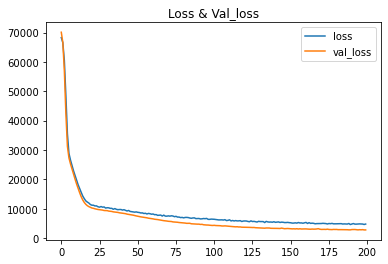

In [27]:
plt.plot(network.history["loss"], label="loss")
plt.plot(network.history["val_loss"], label="val_loss")
plt.legend()
plt.title("Loss & Val_loss")
plt.show()

In [28]:
print("RMSE for Regular Neural Network is:",sqrt(NN.evaluate(X_test,y_test)[1]))

3476/3476 [==============================] - 0s 24us/step
RMSE for Regular Neural Network is: 51.606749479083405


In [29]:
NNprediction = NN.predict(X_test)
residuals = NNprediction-y_test

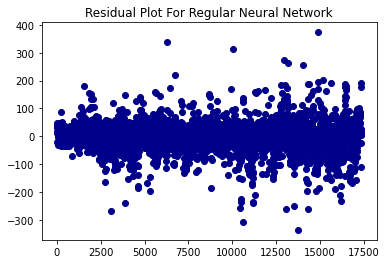

In [69]:
plt.plot(residuals,"o",color="darkblue")
plt.title("Residual Plot For Regular Neural Network")
plt.show()

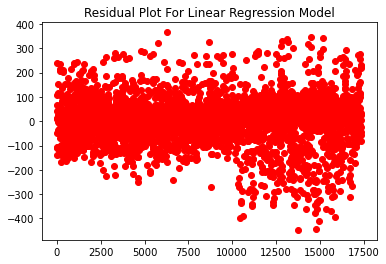

In [31]:
plt.plot(prediction-y_test,"o",color="red")
plt.title("Residual Plot For Linear Regression Model")
plt.show()